In [ ]:
## Notebook env: mirtud_env (R kernel)

In [1]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggpubr)

.libPaths('/home/ssobti/projects/mir_tud/mirtud_conda_extras')
library(ggbreak)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774

In [2]:
adata.tRF = readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF_normalized_integrated_seurat.rds')
meta = adata.tRF@meta.data
meta$guide[stringr::str_sub(meta$guide, 1, 3) == 'TuD'] <- 'TuD_NC'

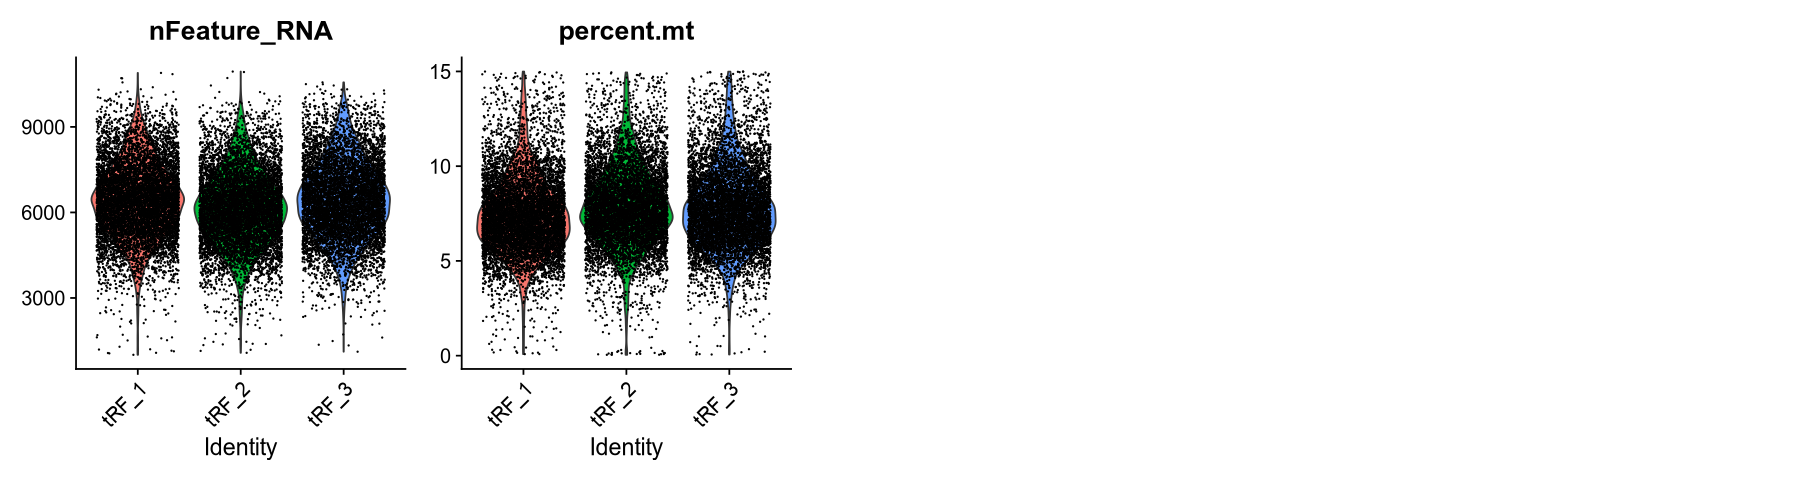

In [3]:
options(repr.plot.width = 15, repr.plot.height = 4)
feats <- c("nFeature_RNA", "percent.mt")
VlnPlot(adata.tRF, group.by = "sample", features = feats, pt.size = 0.01, ncol = 5)

In [ ]:
## Fig 1b stats
print(paste('Total cells:', dim(meta)[1]))
print(paste('Total perturbations:', length(unique(meta$guide))))
print(paste('Number of tRF clusters perturbed:', sum(stringr::str_count(unique(meta$guide), "_") > 2)))
print(paste('Number of unique tRFs perturbed:', length(unique(meta$guide)) - 1 - sum(stringr::str_count(unique(meta$guide), "_") > 2)))
print(paste('Number of cells per perturbation (median):', median(table(meta$guide))))
print(paste('Number of genes per cell (median):', median(meta$nFeature_RNA)))

[1] "Total cells: 23540"
[1] "Total perturbations 196"
[1] "Number of tRF clusters perturbed: 62"
[1] "Number of unique tRFs perturbed: 133"
[1] "Number of cells per perturbation (median): 43"


[1] "Number of genes per cell (median): 6308.5"


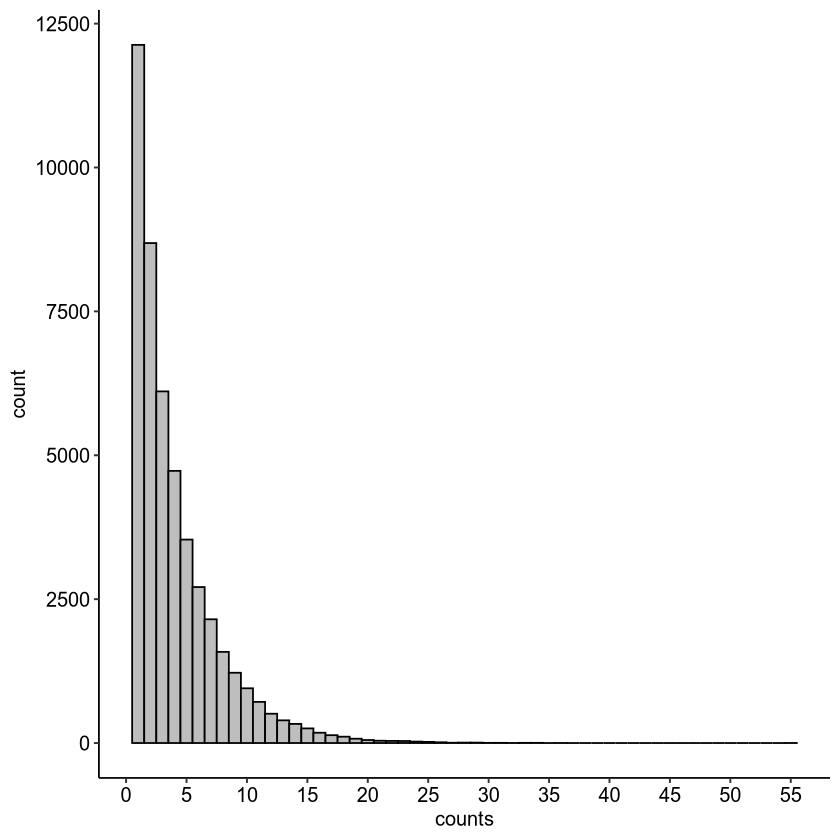

In [3]:
geomux_inputs_tRF = read.csv('/home/ssobti/projects/mir_tud/uploaded_data/geomux_input_and_output_larisa/inputs/tRF.concat.tsv', sep = '\t', header = F)
colnames(geomux_inputs_tRF) = c('barcode', 'guide', 'n_umi')
guides_per_cell_tRF = geomux_inputs_tRF %>% select(barcode, guide) %>% group_by(barcode) %>% summarize(counts = n())
saveRDS(guides_per_cell_tRF, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/guides_per_cell_tRF.rds')
ggplot(guides_per_cell_tRF, aes(x = counts)) + geom_histogram(binwidth = 1, color="black", fill="grey") + theme_pubr() + scale_x_continuous(breaks = seq(0, max(guides_per_cell_tRF$counts), by = 5))

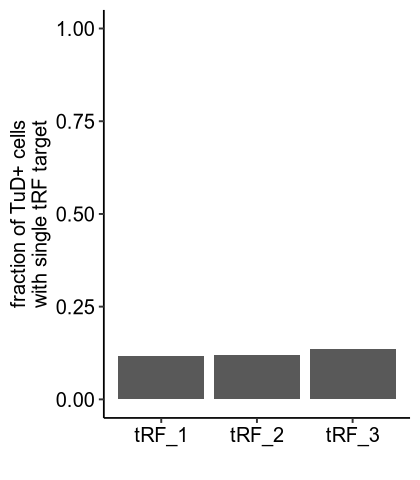

In [4]:
options(repr.plot.width = 3.5, repr.plot.height = 4)
cells_assiged_single_guide = as.data.frame(table(meta$sample)) %>% `colnames<-` (c('well', 'cells_single_guide'))
total_cells = as.data.frame(table(sapply(stringr::str_split(string = geomux_inputs_tRF$barcode, pattern = ":"), '[[', 1))) %>% `colnames<-` (c('well', 'total_cells'))
ratio_df = merge(cells_assiged_single_guide, total_cells, by = 'well')
ratio_df$ratio = ratio_df$cells_single_guide / ratio_df$total_cells
saveRDS(ratio_df, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/tRF_tud_positive_ratio_df.rds')
ratio_df %>% ggplot(aes(x = well, y = ratio)) + geom_bar(stat="identity") + theme_pubr() + ylim(c(0, 1)) + xlab('') + ylab('fraction of TuD+ cells\nwith single tRF target')

In [2]:
adata.tRF = readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF_normalized_integrated_seurat.rds')
trf_cluster_key = read.csv('/home/ssobti/projects/mir_tud/uploaded_data/20220525_tRF_super.tRF_map.tsv', sep='\t')
control_key = data.frame(trf_name = paste0('TuD_NC_', ifelse(1:20 < 10, paste0("0", 1:20), 1:20)), super.trf_name = paste0('TuD_NC_', ifelse(1:20 < 10, paste0("0", 1:20), 1:20)))
trf_cluster_key = rbind(trf_cluster_key, control_key)
meta = adata.tRF@meta.data

trf_cluster_key$cluster_status = ifelse(grepl('_', trf_cluster_key$super.trf_name), 'Cluster', 'Unique')
trf_cluster_key$cluster_status[startsWith(trf_cluster_key$super.trf_name, 'TuD_NC')] = 'Non-targeting Control'

clusters = trf_cluster_key %>% filter(cluster_status == 'Cluster') %>% pull(super.trf_name) %>% unique()
clusters_tRF_dictionary_list = lapply(clusters, function(x) {trf_cluster_key$trf_name[trf_cluster_key$super.trf_name == x]})
names(clusters_tRF_dictionary_list) = clusters
clusters_tRF_dictionary_list = clusters_tRF_dictionary_list[lapply(clusters_tRF_dictionary_list, function(x) {length(x)}) > 1]
filtered_clusters = names(clusters_tRF_dictionary_list)
trf_cluster_key$cluster_status = ifelse(trf_cluster_key$super.trf_name %in% filtered_clusters, 'Cluster', 'Unique')
trf_cluster_key$cluster_status[startsWith(trf_cluster_key$super.trf_name, 'TuD_NC')] = 'Non-targeting Control'

meta$cluster_status = trf_cluster_key[match(meta$guide, trf_cluster_key$super.trf_name), 'cluster_status']
tRF_df = meta %>% group_by(cluster_status) %>% count(guide) %>% `colnames<-`(c('cluster_status', 'guide', 'count'))
tRF_df$cluster_status = factor(tRF_df$cluster_status, levels = c('Non-targeting Control', 'Unique', 'Cluster'))
# saveRDS(tRF_df, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/tRF_qc_cell_guide_counts.rds')

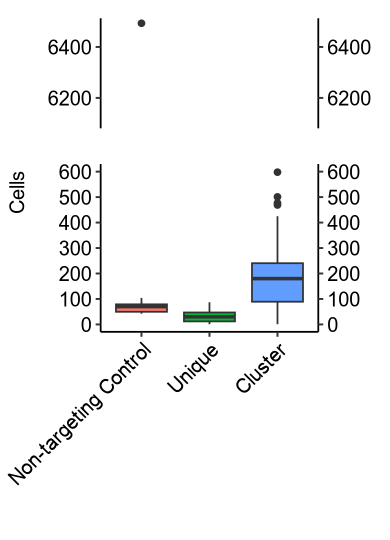

In [3]:
options(repr.plot.width = 3.25, repr.plot.height = 4.5)
tRF_df %>% ggplot(aes(x = cluster_status, y = count, fill = cluster_status)) + xlab('') + geom_boxplot(show.legend = FALSE) + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), axis.title.y = element_text(hjust = 0.64)) + scale_y_continuous(breaks = scales::pretty_breaks(n = 8)) + scale_y_break(c(600, 6100), ticklabels = c(600, 6200, 6400), space = 0.65) +
scale_fill_discrete() + ylab('Cells')

In [5]:
tRF_cluster_df = data.frame(table(trf_cluster_key$cluster_status)) %>% `colnames<-`(c('cluster_status', 'count'))
tRF_cluster_df$percent = (tRF_cluster_df$count / sum(tRF_cluster_df$count)) * 100
tRF_cluster_df$cluster_status = factor(tRF_cluster_df$cluster_status, levels = c('Non-targeting Control', 'Unique', 'Cluster'))
# saveRDS(tRF_cluster_df, '/home/ssobti/projects/mir_tud/fig_output/data/fig1/tRF_qc_cluster_counts.rds')

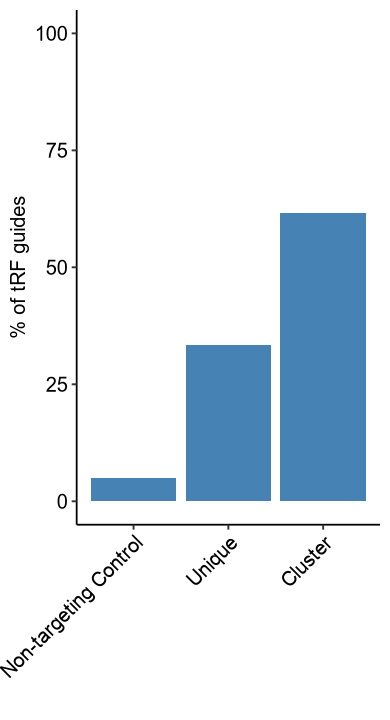

In [6]:
options(repr.plot.width = 3.25, repr.plot.height = 6)
tRF_cluster_df %>% ggplot(aes(x = cluster_status, y = percent)) +
  geom_bar(stat = "identity", fill = "steelblue") + theme_pubr() + ylab('% of tRF guides') + xlab('') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + ylim(c(0, 100))